In [1]:
from gampixpy import config, analysis
from gampixpy.units import *

import numpy as np
import scipy.stats as st
import h5py
import torch

In [2]:
# load config files
detector_config = config.preset_detector_configs['far_detector_vd']
physics_config = config.default_physics_params
readout_config = config.preset_readout_configs['GAMPixD_segment_tagging']

# the input and output files of the simulation for cross-referencing
edepsim_path = '/sdf/data/neutrino/yuntse/lartpc_rd/gampix/g4/rad/fullgeoanatruth-vd-reduced_g4_00.h5'
sim_output_path = '/sdf/data/neutrino/dougl215/gampixpy/rad/rad_fullgeoanatruth-vd-reduced_g4_00_2Mhz_segmentlabel_5labels.h5'

# use the CrossReferenceParser analysis tool for easy browsing of these
# two files in parallel
crp = analysis.CrossReferenceParser(edepsim_path,
                                    sim_output_path,
                                    readout_config=readout_config)

crp.event_id = 1

# now, let's see which labels exist in this file:
# Alternatively, CrossReferenceParser provides an iterable interface,
# so we can just iterate through everything, if desired
crp.label_list

array([ 8441,  8443,  8444, ..., 15683, 15685, 15845], dtype=int32)

In [3]:
# okay, let's grab this segment and its associated hits
crp.label = 9012

# we've set the event_id and label attributes already,
# but we can also call this like crp.get_data(event_id = 1, label = 9885)
# if we want to avoid those steps
edepsim_data, gampixpy_data = crp.get_data()

# this is how you unpack the output of get_data()
# a little cumbersome, I know...
segment_start, segment_end, t_start, t_end, dE, pdg = edepsim_data
pixel_hits, coarse_hits, meta = gampixpy_data

print (segment_start)
print (pixel_hits[0])
print (pixel_hits.dtype)

tensor([[  11.7063, -134.3241,  963.0000]])
(1, 0, -83.25, -134.25, 675.9535, 4221.717, -54.16722, [0.0, 0.0, 0.0, 0.0, 0.0], [ 9012, -9999, -9999, -9999, -9999])
[('event id', '<u4'), ('pixel tpc', '<u4'), ('pixel x', '<f4'), ('pixel y', '<f4'), ('hit z', '<f4'), ('hit t', '<f4'), ('hit charge', '<f4'), ('attribution', '<f4', (5,)), ('label', '<i4', (5,))]


In [4]:
# Let's calculate the depth of the first segment's start point
# by referencing the geometry defined within the detector config file.
depth = torch.dot(segment_start[0] - detector_config['drift_volumes']['volume_0']['anode_center'], 
                  detector_config['drift_volumes']['volume_0']['drift_axis']).item()
print ("depth:", depth/cm, "cm")

depth: 313.2936706542969 cm


/sdf/home/d/dougl215/.local/lib/python3.10/site-packages/gampixpy/coordinates.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords = torch.tensor(coords)[None,:].float()


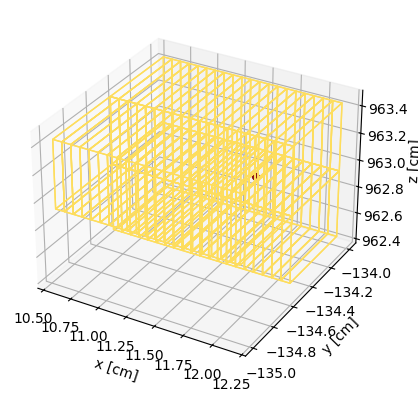

In [5]:
from gampixpy.plotting import *
from gampixpy import coordinates
from gampixpy import readout_objects
coordinate_manager = coordinates.CoordinateManager(detector_config)

# display the G4 segments and the corresponding hit objects
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel(r'x [cm]')
ax.set_ylabel(r'y [cm]')
ax.set_zlabel(r'z [cm]')

for seg_start, seg_stop in zip(segment_start,
                               segment_end):
    seg = np.stack((seg_start, seg_stop))
    ax.plot(*seg.T,
            color = SLACplots.stanford.cardinal_red)
    ax.scatter(*seg_start, 
               color = SLACplots.stanford.cardinal_red)
    ax.scatter(*seg_stop, 
               color = SLACplots.stanford.cardinal_red)
    
# since we don't have a way to measure the time of ionization, 
# let's cheat and figure out the depth offset based on the true
# ionization time.
# This only makes sense to do for a diagnostic plot.
v = physics_config['charge_drift']['drift_speed']
z_offset = -t_start[0]*v

for this_hit in pixel_hits:
    pixel_hit = readout_objects.PixelSample.from_numpy(this_hit)
    plot_pixel_hit(ax, pixel_hit, 
                   coordinate_manager,
                   readout_config,
                   physics_config,
                   detector_config,
                   z_offset = z_offset,
                   )

#plot_lim_margin = 1
#ax.set_xlim(ax.get_xlim()[0]-plot_lim_margin,
#            ax.get_xlim()[1]+plot_lim_margin)
#ax.set_ylim(ax.get_ylim()[0]-plot_lim_margin,
#            ax.get_ylim()[1]+plot_lim_margin)
#ax.set_zlim(ax.get_zlim()[0]-plot_lim_margin,
#            ax.get_zlim()[1]+plot_lim_margin)
    
# un-comment to show the TPC volume boundaries
#plot_drift_volumes(ax,
#                  detector_config)
plt.show()

In [6]:
# let's get the relevant info from the hits for this vertex
# we can measure the pixel position (x-y in TPC coordinates)
# we can also measure the timestamp (assume we don't know t0)
# and the measured charge per hit
hit_x = np.array([this_hit['pixel x'] for this_hit in pixel_hits])
hit_y = np.array([this_hit['pixel y'] for this_hit in pixel_hits])
hit_t = np.array([this_hit['hit t'] for this_hit in pixel_hits])
hit_q = np.array([this_hit['hit charge'] for this_hit in pixel_hits])

hit_x = pixel_hits['pixel x']
hit_y = pixel_hits['pixel y']
hit_t = pixel_hits['hit t']
hit_q = pixel_hits['hit charge']

estimated t center 3.0


/lscratch/dougl215/tmp/ipykernel_1695941/2297335379.py:90: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x_tpc = np.dot(seg_start - detector_config['drift_volumes']['volume_0']['anode_center'],
/lscratch/dougl215/tmp/ipykernel_1695941/2297335379.py:92: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_tpc = np.dot(seg_start - detector_config['drift_volumes']['volume_0']['anode_center'],


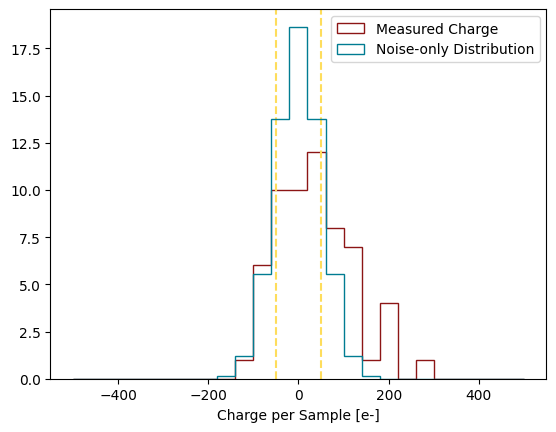

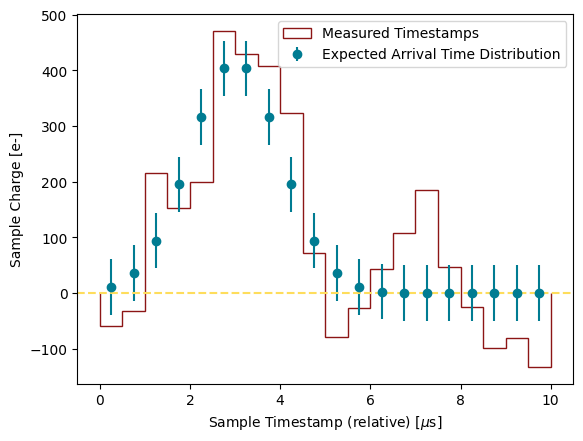

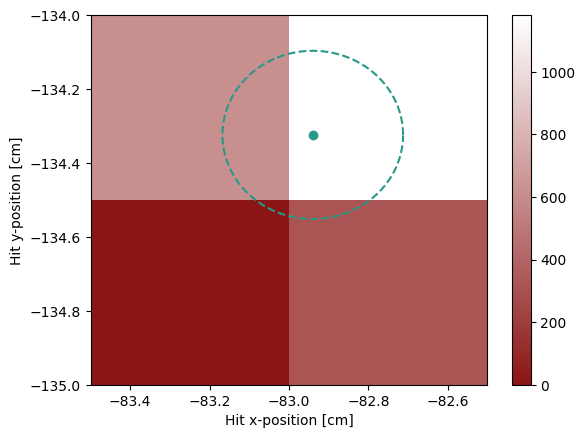

In [7]:
# make some plots of the distributions

# for measured charge, we expect to see most hits are just noise, 
# with one or two hits containing nearly all of the charge
# with diffusion, this charge-sharing between measurement regions
# should become more important
plt.figure()
# plot the measured hit charge
plt.hist(hit_q,
         histtype = 'step',
         #bins = np.logspace(1, 3, 26),
         bins = np.linspace(-500, 500, 26),
         label = 'Measured Charge')
# plot the average noise value
plt.axvline(x = -readout_config['pixels']['noise'],
            ls = '--',
            color = SLACplots.stanford.illuminating)
plt.axvline(x = readout_config['pixels']['noise'],
            ls = '--',
            color = SLACplots.stanford.illuminating)
# plot the expected distribution for a noise-only measurement
N_samples = 10000000
plt.hist(st.norm.rvs(loc = 0, scale=readout_config['pixels']['noise'], size = N_samples),
         histtype = 'step',
         #bins = np.logspace(1, 3, 26),
         bins = np.linspace(-500, 500, 26),
         label = 'Noise-only Distribution',
         weights = hit_q.shape[0]/N_samples*np.ones(N_samples),
        )
plt.legend()
#plt.semilogx()
plt.xlabel(r'Charge per Sample [e-]')

# plot the distribution of charge arrival time 
plt.figure()
n_t_bins = int((np.max(hit_t) - np.min(hit_t))/readout_config['pixels']['clock_interval']) + 1
last_time_tick = n_t_bins*readout_config['pixels']['clock_interval']
t_bins = np.linspace(0, last_time_tick, n_t_bins + 1)
t_bin_centers = 0.5*(t_bins[:-1] + t_bins[1:])

plt.hist(hit_t - np.min(hit_t),
         histtype = 'step',
         weights = hit_q,
         bins = t_bins,
         label = 'Measured Timestamps')

# estimate the center of signal charge
# only consider hits which are 5x the noise level (a bit aggressive!)
above_threshold_mask = hit_q > 5*readout_config['pixels']['noise']
t_center = np.sum(hit_t[above_threshold_mask]*hit_q[above_threshold_mask])/np.sum(hit_q[above_threshold_mask]) - np.min(hit_t)
print ("estimated t center", t_center)

# these are using the true value of the depth
# ...can we estimate the depth from the width instead?
v = physics_config['charge_drift']['drift_speed']
width_longitudinal = np.sqrt(2*physics_config['charge_drift']['diffusion_longitudinal']*(depth/v))
width_transverse = np.sqrt(2*physics_config['charge_drift']['diffusion_transverse']*(depth/v))
t_width = width_longitudinal/v

# the expectation distribution given the estimated mean time and true depth
pmf = st.norm.cdf(t_bins[1:], loc = t_center, scale = t_width) - st.norm.cdf(t_bins[:-1], loc = t_center, scale = t_width)
pmf *= sum(hit_q)

plt.errorbar(t_bin_centers,
             pmf,
             yerr = readout_config['pixels']['noise']*np.ones_like(pmf),
             fmt = 'o',
             label = 'Expected Arrival Time Distribution'
            )
plt.axhline(y = 0, ls = '--', color = SLACplots.stanford.illuminating)
plt.legend()
plt.xlabel(r'Sample Timestamp (relative) [$\mu$s]')
plt.ylabel(r'Sample Charge [e-]')

# plot the distribution of charge arrival position
plt.figure()
pitch = readout_config['pixels']['pitch']
plt.hist2d(hit_x, hit_y,
           bins = (np.linspace(np.min(hit_x) - 0.5*pitch, 
                               np.max(hit_x) + 0.5*pitch, 
                               int((np.max(hit_x) - np.min(hit_x))/pitch + 2)),
                   np.linspace(np.min(hit_y) - 0.5*pitch, 
                               np.max(hit_y) + 0.5*pitch, 
                               int((np.max(hit_y) - np.min(hit_y))/pitch + 2))),
           weights = hit_q)
ax = plt.gca()
for seg_start, seg_stop in zip(segment_start,
                               segment_end):
    seg = np.stack((seg_start, seg_stop))
    x_tpc = np.dot(seg_start - detector_config['drift_volumes']['volume_0']['anode_center'], 
                   detector_config['drift_volumes']['volume_0']['anode_horizontal'])
    y_tpc = np.dot(seg_start - detector_config['drift_volumes']['volume_0']['anode_center'], 
                   detector_config['drift_volumes']['volume_0']['anode_vertical'])
    ax.scatter(x_tpc, y_tpc, color = SLACplots.stanford.palo_verde)
    theta = np.linspace(0, np.pi*2, 1000)[:-1]
    ax.plot(x_tpc + np.cos(theta)*width_transverse.item(),
            y_tpc + np.sin(theta)*width_transverse.item(),
            ls = '--',
            color = SLACplots.stanford.palo_verde,
           )

plt.xlabel(r'Hit x-position [cm]')
plt.ylabel(r'Hit y-position [cm]')
cb = plt.colorbar()